<a href="https://colab.research.google.com/github/Liu-CWB/cwbopendata/blob/master/CWB_NWPOPENDATA_DRAW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please do following command if you want to use cartopy pygrib in colab </br>
!sudo apt-get update </br>
!sudo apt-get -qq install python-cartopy python3-cartopy </br>
!sudo pip uninstall shapely </br>
!sudo pip install shapely --no-binary shapely </br> 
!apt-get install python3-grib </br>

In [2]:
!sudo apt-get update
!sudo apt-get -qq install python-cartopy python3-cartopy
!sudo pip uninstall shapely
!sudo pip install shapely --no-binary shapely
!sudo apt-get install python3-grib

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.download.nvidia.co

In [3]:
"""
Download numerical weather prediction data form CWB opendata website
Example: Download CWB WRF 3km data
Forecast hour: 84
timestamp: every six hours
"""

"""
import requests
urlbase = "https://opendata.cwb.gov.tw/fileapi/opendata/MIC"
dictNwpDataType = {"GFS25KM":"A0060","RFS15KM":"A0061","RFS3KM":"A0064"}

tau = lambda m: "00" + str(m) if m < 10 else "0" + str(m)
for fchr in range(0,85,6):
  filename = "M-{}-{}.grb2".format(dictNwpDataType["RFS3KM"],tau(fchr))
  with open(filename, 'wb') as out:
    url = urlbase + "/" + filename
    r = requests.get(url,stream=True)
    out.write(r.content)
"""
#The code here is for reference. Do not excute this code on colab since may cost much time.

'\nimport requests\nurlbase = "https://opendata.cwb.gov.tw/fileapi/opendata/MIC"\ndictNwpDataType = {"GFS25KM":"A0060","RFS15KM":"A0061","RFS3KM":"A0064"}\n\ntau = lambda m: "00" + str(m) if m < 10 else "0" + str(m)\nfor fchr in range(0,85,6):\n  filename = "M-{}-{}.grb2".format(dictNwpDataType["RFS3KM"],tau(fchr))\n  with open(filename, \'wb\') as out:\n    url = urlbase + "/" + filename\n    r = requests.get(url,stream=True)\n    out.write(r.content)\n'

In [20]:
"""
The grib file from cwb Opendata is downloaded and uploaded to my google drive.
This section shows how to mount your gooledrive. 
"""
from google.colab import drive
drive.mount("data")  #The "data" cant be replaced what ever you want (string type)

"""
As above code, my google drive is mounted and named "data" (drive.mount("data")), the path to goole drive is /content/data/My Drive/
If there is a folder, cool, the path to cool is /content/data/My Drive/cool
"""


Drive already mounted at data; to attempt to forcibly remount, call drive.mount("data", force_remount=True).


'\nAs above code, my google drive is mounted and named "data" (drive.mount("data")), the path to goole drive is /content/data/My Drive/\nIf there is a folder, cool, the path to cool is /content/data/My Drive/cool\n'

In [5]:
"""
The grib data processing by using package pygrib is in this section. 
tips:
open grib file → objectpb = pygrib.open("the path which the girb file exist")
select variable data → var = pbjectb.selct()[the int number coressponding the var you want]["values"]
"""

import pygrib as pb
dataPath = "/content/data/My Drive/Datazone" #grib file put in Datazone folder
fnTau12 = pb.open(dataPath + "/" + "M-A0064-012.grb2")
fnTau06 = pb.open(dataPath + "/" + "M-A0064-006.grb2")

gridx = fnTau12.select()[0]["Nx"]
gridy = fnTau12.select()[0]["Ny"]
lat = fnTau12.select()[0]["latitudes"].reshape(gridy,gridx)[150:450,400:800]
lon = fnTau12.select()[0]["longitudes"].reshape(gridy,gridx)[150:450,400:800]
accRain6Hr = fnTau12.select()[61]["values"][150:450,400:800] - \
         fnTau06.select()[61]["values"][150:450,400:800]
u10 = fnTau12.select()[66]["values"][150:450,400:800]*1.944
v10 = fnTau12.select()[67]["values"][150:450,400:800]*1.944
print(accRain6Hr)

[[2.7350e-01 2.2720e-01 4.6090e-01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.4600e-02 2.6200e-01 1.0520e-01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.2000e-03 6.7990e-01 1.2663e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [3.4174e+00 5.2008e+00 5.3883e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.5852e+00 3.5113e+00 4.5535e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.9210e-01 2.0550e+00 3.4436e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


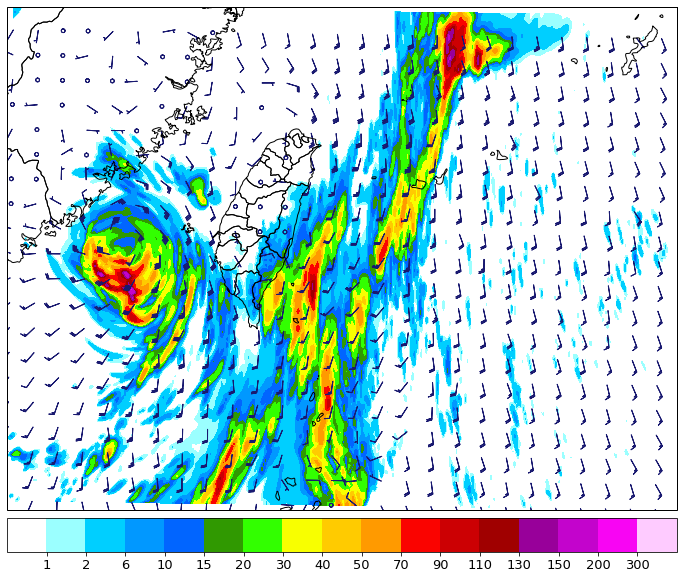

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

lambert = ccrs.LambertConformal(central_longitude=121.76013, \
       central_latitude=24.128498,standard_parallels=(10,40))

fig = plt.figure(figsize=(12,16))
axs = plt.axes(projection=lambert)
dataPath = "/content/data/My Drive/Datazone"

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale='10m',
    )
axs.add_feature(states_provinces,edgecolor='k',facecolor='none')

"""
shapeFilePath = dataPath + "/shpfile/ne_10m_admin_0_countries.shp"
shape_feature = ShapelyFeature(shpreader.Reader(shapeFilePath).geometries(),\
            ccrs.PlateCarree(),facecolor='none',edgecolor='gray')
axs.add_feature(shape_feature)
"""

cwb_data=['None','#9BFFFF','#00CFFF','#0198FF','#0165FF','#309901','#32FF00','#F8FF00','#FFCB00',\
      '#FF9A00','#FA0300','#CC0003', '#A00000','#98009A','#C304CC','#F805F3','#FECBFF']
clevs = [0,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300,400]
cmaps = mcolors.ListedColormap(cwb_data,'precipitation')
norms = mcolors.BoundaryNorm(clevs, cmaps.N)
ctf = plt.contourf(lon,lat,accRain6Hr,clevs,cmap=cmaps,norm=norms,transform=ccrs.PlateCarree())

cbar = plt.colorbar(ctf,orientation="horizontal",ticks=clevs[1:len(clevs)-1],pad=0.01)
cbar.ax.tick_params(labelsize=13)
plt.barbs(lon[::15,::15],lat[::15,::15],u10[::15,::15],v10[::15,::15],length=5,\
          color="midnightblue",transform=ccrs.PlateCarree())
#ax.add_feature(shape_feature)

plt.show()